In [1]:
import numpy as np
import networkx as nx
from scipy import signal
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
import torch.nn.functional as F

class PhaseSpaceTransformer:
    """位相空間再構成と遷移ネットワーク分析"""
    
    def __init__(self, embedding_dim=5, time_delay=5, bin_size=20):
        self.embedding_dim = embedding_dim
        self.time_delay = time_delay
        self.bin_size = bin_size
    
    def reconstruct_phase_space(self, signal):
        """時間遅延埋め込みによる位相空間再構成"""
        N = len(signal) - (self.embedding_dim - 1) * self.time_delay
        phase_space = np.zeros((N, self.embedding_dim))
        
        for i in range(N):
            for j in range(self.embedding_dim):
                phase_space[i, j] = signal[i + j * self.time_delay]
                
        return phase_space
    
    def build_transition_network(self, phase_space):
        """位相空間から遷移ネットワークを構築"""
        # 位相空間を量子化
        mins = np.min(phase_space, axis=0)
        maxs = np.max(phase_space, axis=0)
        bins = np.linspace(mins, maxs, self.bin_size)
        
        # 各点がどのビンに属するかを決定
        indices = np.zeros(phase_space.shape[0], dtype=int)
        for i in range(phase_space.shape[0]):
            idx = 0
            for j in range(self.embedding_dim):
                bin_idx = np.digitize(phase_space[i, j], bins[j]) - 1
                idx += bin_idx * (self.bin_size ** j)
            indices[i] = idx
        
        # 遷移行列を構築
        states = np.max(indices) + 1
        transition_matrix = np.zeros((states, states))
        
        for i in range(len(indices) - 1):
            transition_matrix[indices[i], indices[i+1]] += 1
            
        # 行の和で正規化
        row_sums = transition_matrix.sum(axis=1)
        transition_matrix = transition_matrix / row_sums[:, np.newaxis]
        
        # NaNを0に置き換え
        transition_matrix = np.nan_to_num(transition_matrix)
        
        # NetworkXグラフに変換
        G = nx.from_numpy_array(transition_matrix, create_using=nx.DiGraph)
        
        return G, transition_matrix
        
    def extract_network_features(self, G, transition_matrix):
        """遷移ネットワークから特徴量を抽出"""
        features = {}
        
        # グラフ理論指標
        if len(G.nodes()) > 0:
            features['avg_clustering'] = nx.average_clustering(G)
            features['graph_density'] = nx.density(G)
            
            try:
                features['avg_shortest_path'] = nx.average_shortest_path_length(G)
            except:
                features['avg_shortest_path'] = 0
                
            features['assortativity'] = nx.degree_assortativity_coefficient(G)
            
            # 中心性指標
            in_degree = dict(G.in_degree())
            out_degree = dict(G.out_degree())
            features['avg_in_degree'] = np.mean(list(in_degree.values()))
            features['avg_out_degree'] = np.mean(list(out_degree.values()))
            features['in_degree_variance'] = np.var(list(in_degree.values()))
            
            # 遷移行列の特徴
            features['spectral_radius'] = np.max(np.abs(np.linalg.eigvals(transition_matrix)))
            features['trace'] = np.trace(transition_matrix)
            features['entropy'] = -np.sum(transition_matrix * np.log2(transition_matrix + 1e-10))
        else:
            # Default values if graph is empty
            features = {k: 0 for k in [
                'avg_clustering', 'graph_density', 'avg_shortest_path',
                'assortativity', 'avg_in_degree', 'avg_out_degree',
                'in_degree_variance', 'spectral_radius', 'trace', 'entropy'
            ]}
        
        return features

    def transform(self, signal):
        """信号を特徴量に変換"""
        phase_space = self.reconstruct_phase_space(signal)
        G, transition_matrix = self.build_transition_network(phase_space)
        features = self.extract_network_features(G, transition_matrix)
        
        return features


class TransferEntropyAnalyzer:
    """多スケール転送エントロピー解析"""
    
    def __init__(self, channels, window_size=100, stride=50, k=1, l=1):
        self.channels = channels
        self.window_size = window_size
        self.stride = stride
        self.k = k  # 過去の時系列の長さ
        self.l = l  # 将来の時系列の長さ
    
    def calculate_transfer_entropy(self, source, target):
        """2つの時系列間の転送エントロピーを計算"""
        n = len(source) - self.k - self.l
        
        # 条件付き確率分布を推定するためのヒストグラム
        p_joint = np.zeros((10, 10, 10))  # 簡略化のために10ビンを使用
        p_cond_y = np.zeros((10, 10))
        p_cond_xy = np.zeros((10, 10, 10))
        
        # 時系列を量子化
        source_bins = np.linspace(min(source), max(source), 10)
        target_bins = np.linspace(min(target), max(target), 10)
        
        for t in range(n):
            # 現在の状態
            i = min(int(np.digitize(target[t+self.k+self.l-1], target_bins)), 9)
            # 過去の対象系列
            j = min(int(np.digitize(target[t+self.k-1], target_bins)), 9)
            # 過去の源系列
            k = min(int(np.digitize(source[t+self.k-1], source_bins)), 9)
            
            p_joint[i, j, k] += 1
            p_cond_y[j, k] += 1
            p_cond_xy[i, j, k] += 1
        
        # 正規化
        p_joint = p_joint / n
        p_cond_y = p_cond_y / n
        p_cond_xy = p_cond_xy / n
        
        # エントロピーの計算
        te = 0
        for i in range(10):
            for j in range(10):
                for k in range(10):
                    if p_joint[i, j, k] > 0 and p_cond_y[j, k] > 0:
                        te += p_joint[i, j, k] * np.log2(p_cond_xy[i, j, k] / p_cond_y[j, k])
        
        return te
    
    def analyze_channels(self, eeg_data):
        """複数チャネル間の転送エントロピーを計算"""
        n_channels = len(self.channels)
        te_matrix = np.zeros((n_channels, n_channels))
        
        for i in range(n_channels):
            for j in range(n_channels):
                if i != j:
                    te_matrix[i, j] = self.calculate_transfer_entropy(
                        eeg_data[self.channels[i]], 
                        eeg_data[self.channels[j]]
                    )
        
        return te_matrix
    
    def extract_features(self, te_matrix):
        """転送エントロピー行列から特徴を抽出"""
        features = {}
        
        # 全体の指標
        features['te_mean'] = np.mean(te_matrix)
        features['te_std'] = np.std(te_matrix)
        features['te_max'] = np.max(te_matrix)
        
        # 方向性の指標
        out_flow = np.sum(te_matrix, axis=1)
        in_flow = np.sum(te_matrix, axis=0)
        net_flow = out_flow - in_flow
        
        features['out_flow_mean'] = np.mean(out_flow)
        features['out_flow_std'] = np.std(out_flow)
        features['in_flow_mean'] = np.mean(in_flow)
        features['in_flow_std'] = np.std(in_flow)
        features['net_flow_mean'] = np.mean(net_flow)
        features['net_flow_std'] = np.std(net_flow)
        
        # 非対称性の指標
        asymmetry = te_matrix - te_matrix.T
        features['asymmetry_mean'] = np.mean(np.abs(asymmetry))
        features['asymmetry_std'] = np.std(np.abs(asymmetry))
        
        return features


class DynamicConnectivityNetwork(nn.Module):
    """動的接続性ネットワーク: 時間的に変化する脳領域間の接続性を学習"""
    
    def __init__(self, num_channels, hidden_size=64, num_layers=2):
        super(DynamicConnectivityNetwork, self).__init__()
        self.num_channels = num_channels
        
        # 各チャンネルごとの時間的特徴抽出器
        self.temporal_encoders = nn.ModuleList([
            nn.LSTM(1, hidden_size, num_layers, batch_first=True)
            for _ in range(num_channels)
        ])
        
        # チャンネル間の接続性を学習する注意機構
        self.attention = nn.MultiheadAttention(hidden_size, 4)
        
        # 特徴統合
        self.integrator = nn.Sequential(
            nn.Linear(hidden_size * num_channels, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, 2)  # 2クラス分類
        )
    
    def forward(self, x):
        batch_size, channels, seq_len = x.size()
        
        # 各チャンネルの時間的特徴を抽出
        channel_features = []
        for i in range(self.num_channels):
            channel_input = x[:, i, :].unsqueeze(-1)  # [batch, seq_len, 1]
            output, (h_n, _) = self.temporal_encoders[i](channel_input)
            channel_features.append(h_n[-1])  # 最後の隠れ状態を使用
        
        # チャンネル特徴を積み重ねる [batch, channels, hidden]
        stacked_features = torch.stack(channel_features, dim=1)
        
        # 自己注意機構を適用して接続性を学習
        attn_output, _ = self.attention(
            stacked_features, stacked_features, stacked_features
        )
        
        # 特徴を平坦化して統合
        flattened = attn_output.reshape(batch_size, -1)
        logits = self.integrator(flattened)
        
        return logits


class EEGAlertnessDrowsinessClassifier(BaseEstimator, ClassifierMixin):
    """脳波の覚醒・眠気状態分類器"""
    
    def __init__(self, channels=None, sample_rate=256, window_size=4, 
                 embedding_dim=5, time_delay=5):
        self.channels = channels
        self.sample_rate = sample_rate
        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.time_delay = time_delay
        
        # 特徴抽出器を初期化
        self.phase_space_analyzer = PhaseSpaceTransformer(
            embedding_dim=embedding_dim,
            time_delay=time_delay
        )
        
        # ディープラーニングモデル
        if channels is not None:
            self.deep_model = DynamicConnectivityNetwork(len(channels))
        else:
            self.deep_model = None
    
    def preprocess_signal(self, signal):
        """信号の前処理"""
        # 帯域通過フィルタ (0.5-45Hz)
        b, a = signal.butter(4, [0.5, 45], fs=self.sample_rate, btype='band')
        filtered = signal.filtfilt(b, a, signal)
        
        # 正規化
        normalized = (filtered - np.mean(filtered)) / np.std(filtered)
        
        return normalized
    
    def extract_traditional_features(self, signal):
        """伝統的な特徴を抽出"""
        # 周波数領域の特徴
        freqs, psd = signal.welch(signal, self.sample_rate, nperseg=self.sample_rate)
        
        # 各周波数帯のパワー
        delta_power = np.sum(psd[(freqs >= 0.5) & (freqs <= 4)])
        theta_power = np.sum(psd[(freqs >= 4) & (freqs <= 8)])
        alpha_power = np.sum(psd[(freqs >= 8) & (freqs <= 13)])
        beta_power = np.sum(psd[(freqs >= 13) & (freqs <= 30)])
        gamma_power = np.sum(psd[(freqs >= 30) & (freqs <= 45)])
        
        total_power = delta_power + theta_power + alpha_power + beta_power + gamma_power
        
        # 相対パワー比
        features = {
            'delta_ratio': delta_power / total_power,
            'theta_ratio': theta_power / total_power,
            'alpha_ratio': alpha_power / total_power,
            'beta_ratio': beta_power / total_power,
            'gamma_ratio': gamma_power / total_power,
            'alpha_theta_ratio': alpha_power / theta_power if theta_power > 0 else 0,
            'theta_alpha_ratio': theta_power / alpha_power if alpha_power > 0 else 0,
            'beta_alpha_ratio': beta_power / alpha_power if alpha_power > 0 else 0,
            'theta_beta_ratio': theta_power / beta_power if beta_power > 0 else 0,
        }
        
        # 時間領域の特徴
        features['mean'] = np.mean(signal)
        features['std'] = np.std(signal)
        features['kurtosis'] = scipy.stats.kurtosis(signal)
        features['skewness'] = scipy.stats.skew(signal)
        
        # 非線形特徴
        # Hurst指数
        features['hurst'] = self.compute_hurst_exponent(signal)
        
        # サンプルエントロピー
        features['sample_entropy'] = self.compute_sample_entropy(signal)
        
        return features
    
    def compute_hurst_exponent(self, signal, max_lag=20):
        """ハースト指数を計算"""
        lags = range(2, max_lag)
        tau = [np.std(np.subtract(signal[lag:], signal[:-lag])) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return poly[0]
    
    def compute_sample_entropy(self, signal, m=2, r=0.2):
        """サンプルエントロピーを計算"""
        r = r * np.std(signal)
        n = len(signal)
        
        # Count vector matches
        def count_matches(x, m, r):
            count = 0
            for i in range(len(x) - m):
                template = x[i:i+m]
                for j in range(i+1, len(x) - m):
                    candidate = x[j:j+m]
                    if np.max(np.abs(template - candidate)) < r:
                        count += 1
            return count
        
        # Count matches for m and m+1
        A = count_matches(signal, m, r)
        B = count_matches(signal, m+1, r)
        
        # Compute sample entropy
        if A == 0 or B == 0:
            return 0
        return -np.log(B / A)
    
    def extract_features(self, signal):
        """信号から全ての特徴を抽出"""
        # 前処理
        preprocessed = self.preprocess_signal(signal)
        
        # 伝統的な特徴
        traditional_features = self.extract_traditional_features(preprocessed)
        
        # 位相空間再構成と遷移ネットワーク分析
        phase_space_features = self.phase_space_analyzer.transform(preprocessed)
        
        # 全ての特徴を結合
        all_features = {**traditional_features, **phase_space_features}
        
        return all_features
    
    def fit(self, X, y):
        """クラス分類モデルを学習"""
        # 特徴抽出
        features = []
        for signal in X:
            features.append(self.extract_features(signal))
        
        # 特徴量をニューラルネットワークで学習
        pass
    
    def predict(self, X):
        """新しい信号のクラスを予測"""
        pass


# 使用例
if __name__ == "__main__":
    # 信号データをロード
    # ここでは例として乱数を使用
    sample_rate = 512
    duration = 5  # 5秒間
    t = np.linspace(0, duration, sample_rate * duration)
    
    # 覚醒状態の信号 (より高い周波数成分)
    alert_signal = (np.sin(2 * np.pi * 10 * t) + 
                    0.5 * np.sin(2 * np.pi * 20 * t) + 
                    0.3 * np.random.randn(len(t)))
    
    # 眠気状態の信号 (より低い周波数成分)
    drowsy_signal = (np.sin(2 * np.pi * 5 * t) + 
                     0.8 * np.sin(2 * np.pi * 8 * t) + 
                     0.3 * np.random.randn(len(t)))
    
    # 特徴抽出をテスト
    classifier = EEGAlertnessDrowsinessClassifier(sample_rate=sample_rate)
    
    alert_features = classifier.extract_features(alert_signal)
    drowsy_features = classifier.extract_features(drowsy_signal)
    
    print("Alert Features:")
    for k, v in alert_features.items():
        print(f"{k}: {v}")
    
    print("\nDrowsy Features:")
    for k, v in drowsy_features.items():
        print(f"{k}: {v}")

AttributeError: 'numpy.ndarray' object has no attribute 'butter'

In [2]:
import numpy as np
import networkx as nx
from scipy import signal, stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

class EEGDataset(Dataset):
    """PyTorch Dataset for EEG data"""
    
    def __init__(self, X, y=None, transform=None):
        """
        Args:
            X (ndarray): EEG segments of shape (n_segments, n_datapoints)
            y (ndarray, optional): Labels of shape (n_segments,)
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sample = self.X[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        if self.y is not None:
            return torch.FloatTensor(sample), torch.LongTensor([self.y[idx]])[0]
        else:
            return torch.FloatTensor(sample)


class PhaseSpaceTransformer:
    """位相空間再構成と遷移ネットワーク分析"""
    
    def __init__(self, embedding_dim=5, time_delay=5, bin_size=20):
        self.embedding_dim = embedding_dim
        self.time_delay = time_delay
        self.bin_size = bin_size
    
    def reconstruct_phase_space(self, signal):
        """時間遅延埋め込みによる位相空間再構成"""
        N = len(signal) - (self.embedding_dim - 1) * self.time_delay
        phase_space = np.zeros((N, self.embedding_dim))
        
        for i in range(N):
            for j in range(self.embedding_dim):
                phase_space[i, j] = signal[i + j * self.time_delay]
                
        return phase_space
    
    def build_transition_network(self, phase_space):
        """位相空間から遷移ネットワークを構築"""
        # 位相空間を量子化
        mins = np.min(phase_space, axis=0)
        maxs = np.max(phase_space, axis=0)
        bins = [np.linspace(mins[j], maxs[j], self.bin_size) for j in range(self.embedding_dim)]
        
        # 各点がどのビンに属するかを決定
        indices = np.zeros(phase_space.shape[0], dtype=int)
        for i in range(phase_space.shape[0]):
            idx = 0
            for j in range(self.embedding_dim):
                bin_idx = np.digitize(phase_space[i, j], bins[j]) - 1
                bin_idx = min(bin_idx, self.bin_size - 1)  # 範囲外の値を処理
                idx += bin_idx * (self.bin_size ** j)
            indices[i] = idx
        
        # 遷移行列を構築
        max_idx = np.max(indices)
        states = max_idx + 1
        transition_matrix = np.zeros((states, states))
        
        for i in range(len(indices) - 1):
            transition_matrix[indices[i], indices[i+1]] += 1
            
        # 行の和で正規化
        row_sums = transition_matrix.sum(axis=1)
        valid_rows = row_sums > 0
        transition_matrix[valid_rows] = transition_matrix[valid_rows] / row_sums[valid_rows, np.newaxis]
        
        # NaNを0に置き換え
        transition_matrix = np.nan_to_num(transition_matrix)
        
        # NetworkXグラフに変換
        G = nx.from_numpy_array(transition_matrix, create_using=nx.DiGraph)
        
        return G, transition_matrix
        
    def extract_network_features(self, G, transition_matrix):
        """遷移ネットワークから特徴量を抽出"""
        features = {}
        
        # グラフ理論指標
        if len(G.nodes()) > 0:
            features['avg_clustering'] = nx.average_clustering(G)
            features['graph_density'] = nx.density(G)
            
            # 最大連結成分のみを考慮
            largest_cc = max(nx.weakly_connected_components(G), key=len)
            largest_subgraph = G.subgraph(largest_cc)
            
            try:
                if len(largest_cc) > 1:
                    features['avg_shortest_path'] = nx.average_shortest_path_length(largest_subgraph)
                else:
                    features['avg_shortest_path'] = 0
            except:
                features['avg_shortest_path'] = 0
                
            try:
                features['assortativity'] = nx.degree_assortativity_coefficient(G)
            except:
                features['assortativity'] = 0
            
            # 中心性指標
            in_degree = dict(G.in_degree())
            out_degree = dict(G.out_degree())
            if len(in_degree) > 0:
                features['avg_in_degree'] = np.mean(list(in_degree.values()))
                features['avg_out_degree'] = np.mean(list(out_degree.values()))
                features['in_degree_variance'] = np.var(list(in_degree.values()))
            else:
                features['avg_in_degree'] = 0
                features['avg_out_degree'] = 0
                features['in_degree_variance'] = 0
            
            # 遷移行列の特徴
            try:
                features['spectral_radius'] = np.max(np.abs(np.linalg.eigvals(transition_matrix)))
            except:
                features['spectral_radius'] = 0
            
            features['trace'] = np.trace(transition_matrix)
            features['entropy'] = -np.sum(transition_matrix * np.log2(transition_matrix + 1e-10))
        else:
            # Default values if graph is empty
            features = {k: 0 for k in [
                'avg_clustering', 'graph_density', 'avg_shortest_path',
                'assortativity', 'avg_in_degree', 'avg_out_degree',
                'in_degree_variance', 'spectral_radius', 'trace', 'entropy'
            ]}
        
        return features

    def transform(self, signal):
        """信号を特徴量に変換"""
        phase_space = self.reconstruct_phase_space(signal)
        G, transition_matrix = self.build_transition_network(phase_space)
        features = self.extract_network_features(G, transition_matrix)
        
        return features


class DynamicConnectivityNetwork(nn.Module):
    """動的接続性ネットワーク: 時間的に変化する脳の接続性を学習"""
    
    def __init__(self, input_size=2560, hidden_size=128, num_layers=2, dropout=0.5):
        super(DynamicConnectivityNetwork, self).__init__()
        
        # 1D CNN による時間的特徴抽出
        self.conv1 = nn.Conv1d(1, 16, kernel_size=64, stride=8)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=32, stride=4)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=16, stride=2)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # 特徴マップのサイズを計算
        self._feature_size = self._get_conv_output_size(input_size)
        
        # 時間的特徴を処理するLSTM
        self.lstm = nn.LSTM(64, hidden_size, num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(hidden_size * 2, 4)
        
        # 分類器
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 2)  # 2クラス分類
        )
    
    def _get_conv_output_size(self, input_size):
        """畳み込みネットワークの出力サイズを計算"""
        dummy_input = torch.zeros(1, 1, input_size)
        x = self.conv1(dummy_input)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x.size(2)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # 入力を(batch, channels, time)の形式に変更
        x = x.unsqueeze(1)  # [batch, 1, time]
        
        # 畳み込みレイヤーを適用
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # 時間次元とチャンネル次元を入れ替え [batch, time, channels]
        x = x.permute(0, 2, 1)
        
        # LSTMによる時間的特徴の処理
        lstm_out, _ = self.lstm(x)
        
        # 自己注意機構を適用
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # グローバル時間プーリング
        global_features = torch.mean(attn_output, dim=1)
        
        # 分類
        logits = self.classifier(global_features)
        
        return logits


class EEGAlertnessDrowsinessClassifier(BaseEstimator, ClassifierMixin):
    """脳波の覚醒・眠気状態分類器"""
    
    def __init__(self, sample_rate=512, window_size=5, embedding_dim=5, time_delay=5, 
                 batch_size=32, epochs=50, lr=0.001, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.sample_rate = sample_rate
        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.time_delay = time_delay
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.device = device
        
        # 各セグメントのデータポイント数
        self.data_points = sample_rate * window_size
        
        # 特徴抽出器を初期化
        self.phase_space_analyzer = PhaseSpaceTransformer(
            embedding_dim=embedding_dim,
            time_delay=time_delay
        )
        
        # ディープラーニングモデル
        self.model = DynamicConnectivityNetwork(input_size=self.data_points)
        self.model.to(self.device)
        
        # スケーラー
        self.scaler = StandardScaler()
        
        # 学習済みフラグ
        self.is_fitted = False
    
    def preprocess_signal(self, signal):
        """信号の前処理"""
        # 帯域通過フィルタ (0.5-45Hz)
        b, a = signal.butter(4, [0.5, 45], fs=self.sample_rate, btype='band')
        filtered = signal.filtfilt(b, a, signal)
        
        # 正規化
        normalized = (filtered - np.mean(filtered)) / np.std(filtered)
        
        return normalized
    
    def extract_traditional_features(self, signal):
        """伝統的な特徴を抽出"""
        # 周波数領域の特徴
        freqs, psd = signal.welch(signal, self.sample_rate, nperseg=self.sample_rate)
        
        # 各周波数帯のパワー
        delta_power = np.sum(psd[(freqs >= 0.5) & (freqs <= 4)])
        theta_power = np.sum(psd[(freqs >= 4) & (freqs <= 8)])
        alpha_power = np.sum(psd[(freqs >= 8) & (freqs <= 13)])
        beta_power = np.sum(psd[(freqs >= 13) & (freqs <= 30)])
        gamma_power = np.sum(psd[(freqs >= 30) & (freqs <= 45)])
        
        total_power = delta_power + theta_power + alpha_power + beta_power + gamma_power
        if total_power == 0:
            total_power = 1  # ゼロ除算を避ける
        
        # 相対パワー比
        features = {
            'delta_ratio': delta_power / total_power,
            'theta_ratio': theta_power / total_power,
            'alpha_ratio': alpha_power / total_power,
            'beta_ratio': beta_power / total_power,
            'gamma_ratio': gamma_power / total_power,
            'alpha_theta_ratio': alpha_power / theta_power if theta_power > 0 else 0,
            'theta_alpha_ratio': theta_power / alpha_power if alpha_power > 0 else 0,
            'beta_alpha_ratio': beta_power / alpha_power if alpha_power > 0 else 0,
            'theta_beta_ratio': theta_power / beta_power if beta_power > 0 else 0,
        }
        
        # 時間領域の特徴
        features['mean'] = np.mean(signal)
        features['std'] = np.std(signal)
        features['kurtosis'] = stats.kurtosis(signal)
        features['skewness'] = stats.skew(signal)
        
        # 非線形特徴
        # Hurst指数
        features['hurst'] = self.compute_hurst_exponent(signal)
        
        # サンプルエントロピー
        features['sample_entropy'] = self.compute_sample_entropy(signal)
        
        return features
    
    def compute_hurst_exponent(self, signal, max_lag=20):
        """ハースト指数を計算"""
        lags = range(2, max_lag)
        tau = [np.std(np.subtract(signal[lag:], signal[:-lag])) for lag in lags]
        if all(t == 0 for t in tau):
            return 0.5  # デフォルト値
        
        # 対数空間での線形フィット
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        return poly[0]
    
    def compute_sample_entropy(self, signal, m=2, r=0.2):
        """サンプルエントロピーを計算"""
        # 信号の標準偏差が0の場合は高いエントロピーを返す
        if np.std(signal) == 0:
            return 0
        
        r = r * np.std(signal)
        n = len(signal)
        
        # 計算を高速化するためにサブサンプリング
        if n > 1000:
            step = n // 1000
            signal = signal[::step]
            n = len(signal)
        
        # Count vector matches
        def count_matches(x, m, r):
            count = 0
            for i in range(len(x) - m):
                template = x[i:i+m]
                for j in range(i+1, len(x) - m):
                    candidate = x[j:j+m]
                    if np.max(np.abs(template - candidate)) < r:
                        count += 1
            return count
        
        # Count matches for m and m+1
        A = count_matches(signal, m, r)
        B = count_matches(signal, m+1, r)
        
        # Compute sample entropy
        if A == 0 or B == 0:
            return 0
        return -np.log(B / A)
    
    def extract_features(self, X):
        """複数の信号から特徴を抽出"""
        features_list = []
        
        for signal in X:
            # 前処理
            preprocessed = self.preprocess_signal(signal)
            
            # 伝統的な特徴
            traditional_features = self.extract_traditional_features(preprocessed)
            
            # 位相空間再構成と遷移ネットワーク分析
            phase_space_features = self.phase_space_analyzer.transform(preprocessed)
            
            # 全ての特徴を結合
            all_features = {**traditional_features, **phase_space_features}
            
            # 特徴をリストに追加
            features_list.append(list(all_features.values()))
        
        # 特徴行列を返す
        return np.array(features_list)
    
    def fit(self, X, y):
        """モデルを学習"""
        print(f"Training on {len(X)} samples with shape {X.shape}")
        
        # PyTorchデータセットとデータローダーを作成
        train_dataset = EEGDataset(X, y)
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4
        )
        
        # オプティマイザとロス関数を設定
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        # 学習ループ
        self.model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                # 勾配をゼロにリセット
                optimizer.zero_grad()
                
                # 順伝播 + 誤差逆伝播 + 最適化
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # 統計情報を収集
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            # エポックごとの結果を表示
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100 * correct / total
            if (epoch + 1) % 5 == 0:
                print(f'Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
        
        self.is_fitted = True
        return self
    
    def predict(self, X):
        """予測を行う"""
        if not self.is_fitted:
            raise ValueError("Model is not fitted yet.")
        
        # PyTorchデータセットとデータローダーを作成
        test_dataset = EEGDataset(X)
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4
        )
        
        # 評価モードに設定
        self.model.eval()
        
        # 予測
        predictions = []
        with torch.no_grad():
            for inputs in test_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        """確率予測を行う"""
        if not self.is_fitted:
            raise ValueError("Model is not fitted yet.")
        
        # PyTorchデータセットとデータローダーを作成
        test_dataset = EEGDataset(X)
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4
        )
        
        # 評価モードに設定
        self.model.eval()
        
        # 予測
        probabilities = []
        with torch.no_grad():
            for inputs in test_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                probs = F.softmax(outputs, dim=1)
                probabilities.extend(probs.cpu().numpy())
        
        return np.array(probabilities)
    
    def score(self, X, y):
        """モデルの性能を評価"""
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def evaluate(self, X, y):
        """モデルの詳細な評価"""
        y_pred = self.predict(X)
        y_prob = self.predict_proba(X)
        
        accuracy = accuracy_score(y, y_pred)
        conf_matrix = confusion_matrix(y, y_pred)
        report = classification_report(y, y_pred)
        
        print(f"Accuracy: {accuracy:.4f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(report)
        
        # ROC曲線のプロット
        if y_prob.shape[1] == 2:  # バイナリ分類の場合
            from sklearn.metrics import roc_curve, auc
            fpr, tpr, _ = roc_curve(y, y_prob[:, 1])
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(10, 8))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()
        
        return accuracy, conf_matrix, report


# 使用例
def main():
    # データの準備 (仮想データ)
    # 実際のデータセットに合わせて変更する必要があります
    np.random.seed(42)
    
    # 5秒 x 512 Hz = 2560 ポイント
    n_samples = 500
    sample_points = 2560
    
    # 仮想的な脳波データを生成
    X = np.zeros((n_samples, sample_points))
    y = np.zeros(n_samples)
    
    # 覚醒状態のデータ (より高い周波数成分)
    n_alert = n_samples // 2
    t = np.linspace(0, 5, sample_points)
    
    for i in range(n_alert):
        # 覚醒状態 (高周波数優位)
        X[i] = (np.sin(2 * np.pi * 10 * t) + 
                0.5 * np.sin(2 * np.pi * 20 * t) + 
                0.3 * np.random.randn(len(t)))
        y[i] = 0  # 覚醒状態をクラス0とする
    
    for i in range(n_alert, n_samples):
        # 眠気状態 (低周波数優位)
        X[i] = (np.sin(2 * np.pi * 5 * t) + 
                0.8 * np.sin(2 * np.pi * 8 * t) + 
                0.3 * np.random.randn(len(t)))
        y[i] = 1  # 眠気状態をクラス1とする
    
    # トレーニングセットとテストセットに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"X_train.shape: {X_train.shape}")  # (400, 2560)
    print(f"X_test.shape: {X_test.shape}")    # (100, 2560)
    print(f"y_train.shape: {y_train.shape}")  # (400,)
    print(f"y_test.shape: {y_test.shape}")    # (100,)
    
    # モデルを初期化
    classifier = EEGAlertnessDrowsinessClassifier(
        sample_rate=512,
        window_size=5,
        batch_size=32,
        epochs=20
    )
    
    # モデルを学習
    classifier.fit(X_train, y_train)
    
    # モデルを評価
    classifier.evaluate(X_test, y_test)


if __name__ == "__main__":
    main()

X_train.shape: (400, 2560)
X_test.shape: (100, 2560)
y_train.shape: (400,)
y_test.shape: (100,)


RuntimeError: max_pool1d() Invalid computed output size: 0

# データ準備

チャンネル:  Fz
----------------------------------------
バンドパスフィルタ:  0.5 - 40.0 Hz
標準化しました。
正規化しました。
外れ値除去しました。
----------------------------------------


0it [00:00, ?it/s]

['12', '1']
12-1 をキーに追加しました
['10', '1']
10-1 をキーに追加しました
['8', '1']
8-1 をキーに追加しました
['13', '2']
13-2 をキーに追加しました
['5', '1']
5-1 をキーに追加しました
['1', '1']
1-1 をキーに追加しました
['3', '2']
3-2 をキーに追加しました
['3', '1']
3-1 をキーに追加しました
['6', '2']
6-2 をキーに追加しました
['6', '1']
6-1 をキーに追加しました
['2', '1']


1it [00:00,  1.45it/s]

2-1 をキーに追加しました
['10', '3']
10-3 をキーに追加しました
['8', '3']
8-3 をキーに追加しました
['14', '3']
14-3 をキーに追加しました
['14', '2']
14-2 をキーに追加しました
['11', '2']
11-2 をキーに追加しました
['11', '3']
11-3 をキーに追加しました
['9', '3']
9-3 をキーに追加しました
['5', '3']
5-3 をキーに追加しました
['5', '2']
5-2 をキーに追加しました
['7', '3']
7-3 をキーに追加しました
['1', '3']
1-3 をキーに追加しました
['6', '3']


2it [00:01,  1.26it/s]

6-3 をキーに追加しました
['4', '3']
4-3 をキーに追加しました
['4', '2']
4-2 をキーに追加しました
['2', '2']
2-2 をキーに追加しました
----------------------------------------
ウィンドウ: 5秒, スライド: 1秒でデータのセグメンテーションが完了しました。
----------------------------------------
データがセグメントされた辞書: split_data_dic
ラベルの取り出し例: label = list(split_data_dic["1-1"])
データの取り出し例: data = split_data_dic["1-1"][label]
セグメントされた行列データ形状:  (596, 2560)
----------------------------------------
セグメントされたデータの取り出しが完了しました。
セグメントされたデータの形状:  (596, 2560)


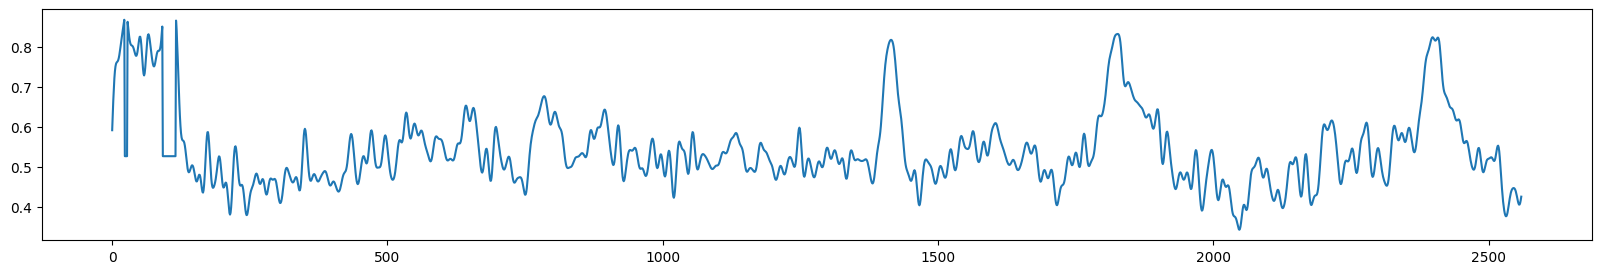

In [4]:
# ディレクトリを親ディレクトリに移動する
# c:\Users\panga\Documents\research\drowsiness_detection_independentにいるのを確認

# 辞書データの作成
import sys
sys.path.append('./independent_project')  # ライブラリのファイルがあるディレクトリを追加
import load_data, preprocessing, need_utils
import numpy as np


CHANNEL = "Fz"  # チャンネル名
print("チャンネル: ", CHANNEL)

WINDOW_SEC = 5  # 分割するウィンドウサイズ（秒）
OVER_SEC = 4  # オーバーラップする時間（秒）
SLIDE_SEC = WINDOW_SEC - OVER_SEC  # スライドする時間（秒）

# EMGの有効周波数帯は0-500Hzなのでバンドパスフィルタはかけない
BANDPASS = True  # True: バンドパスフィルタをかける / False: バンドパスフィルタをかけない
FS = 512
LOWCUT = 0.5
HIGHCUT = 40.0

STANDARDIZATION = True
NORMALIZATION = True
REMOVE_OUTLIERS = True

DOWNSAMPLING = False  # True: ダウンサンプリングを行う / False: ダウンサンプリングを行わない
FR = 64
CUTOFF = FR/2


# 適用した前処理の表示
print("----------------------------------------")
if BANDPASS:
    print("バンドパスフィルタ: ", f"{LOWCUT} - {HIGHCUT} Hz")
if STANDARDIZATION:
    print("標準化しました。")
if NORMALIZATION:
    print("正規化しました。")
if REMOVE_OUTLIERS:
    print("外れ値除去しました。")
if DOWNSAMPLING:
    print("ダウンサンプリングしました。")
    print("ダウンサンプリング後のサンプリング周波数: ", FR, "Hz")
print("----------------------------------------")


# 被験者の実験データを辞書に格納
data_dic = load_data.create_dataset_for_independent(CHANNEL, BANDPASS, FS, LOWCUT, HIGHCUT, STANDARDIZATION, NORMALIZATION, REMOVE_OUTLIERS, DOWNSAMPLING, CUTOFF, FR, WINDOW_SEC, OVER_SEC)


# 被験者のデータリスト
subj_list = [
    "1-1", "1-3",
    "2-1", "2-2",
    "3-1", "3-2",
    "4-2", "4-3",
    "5-1", "5-2", "5-3",
    "6-1", "6-2", "6-3",
    "7-3",
    "8-1", "8-3",
    "9-3",
    "10-1", "10-3",
    "11-2", "11-3",
    "12-1",
    "13-2",
    "14-2", "14-3"
]



# 辞書内データのセグメンテーション
split_data_dic = preprocessing.split_data_by_subject(data_dic, WINDOW_SEC, SLIDE_SEC)  # 辞書内のデータを分割
print("----------------------------------------")
print("データがセグメントされた辞書: split_data_dic")
print("ラベルの取り出し例: label = list(split_data_dic[\"1-1\"])")  # ラベルの取り出し例
print("データの取り出し例: data = split_data_dic[\"1-1\"][label]")  # データの取り出し例
print("セグメントされた行列データ形状: ", np.array(list(split_data_dic["1-1"].values())[0]).shape)  # 分割されたデータの形状を表示



# セグメントされたデータの取り出し（例）
segments = need_utils.get_segments_from_split_data(split_data_dic, "1-1")
print("セグメントされたデータの形状: ", segments.shape)  # セグメントされたデータの形状を表示 --> (セグメント数, サンプル数)


import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(segments[0])
plt.show()


# trainデータセット作成

In [5]:
subj_list = [
    ["1-1", "1-3"], 
    ["2-1", "2-2"], 
    ["3-1", "3-2"],
    ["4-2", "4-3"],
    ["5-1", "5-2", "5-3"],
    ["6-1", "6-2", "6-3"],
    ["7-3"],
    ["8-1", "8-3"],
    ["9-3"],
    ["10-1", "10-3"],
    ["11-2", "11-3"],
    ["12-1"],
    ["13-2"],
    ["14-2", "14-3"]
]

test_subj_list = [["1-1", "1-3"]]  # テスト被験者

train_subj_list = [subj for subj in subj_list if subj not in test_subj_list]

train_segments = []
train_labels = []


for experiments in train_subj_list:
    print(experiments)
    for subj_experiment in experiments:
        segments = need_utils.get_segments_from_split_data(split_data_dic, subj_experiment)
        label = list(split_data_dic[subj_experiment].keys()) * len(segments)
        train_segments.append(segments)
        train_labels.append(label)

    X = np.concatenate(np.array(train_segments), axis=0)
    y = np.concatenate(np.array(train_labels), axis=0)

print("X: ", X.shape)
print("y: ", y.shape)

['2-1', '2-2']
----------------------------------------
セグメントされたデータの取り出しが完了しました。
----------------------------------------
セグメントされたデータの取り出しが完了しました。
['3-1', '3-2']
----------------------------------------
セグメントされたデータの取り出しが完了しました。
----------------------------------------
セグメントされたデータの取り出しが完了しました。
['4-2', '4-3']
----------------------------------------
セグメントされたデータの取り出しが完了しました。
----------------------------------------
セグメントされたデータの取り出しが完了しました。
['5-1', '5-2', '5-3']
----------------------------------------
セグメントされたデータの取り出しが完了しました。
----------------------------------------
セグメントされたデータの取り出しが完了しました。
----------------------------------------
セグメントされたデータの取り出しが完了しました。
['6-1', '6-2', '6-3']
----------------------------------------
セグメントされたデータの取り出しが完了しました。
----------------------------------------
セグメントされたデータの取り出しが完了しました。
----------------------------------------
セグメントされたデータの取り出しが完了しました。
['7-3']
----------------------------------------
セグメントされたデータの取り出しが完了しました。
['8-1', '8-3']
------------------------------

In [7]:
import numpy as np
import networkx as nx
from scipy import signal, stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [8]:
# トレーニングセットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train.shape: {X_train.shape}")  # (400, 2560)
print(f"X_test.shape: {X_test.shape}")    # (100, 2560)
print(f"y_train.shape: {y_train.shape}")  # (400,)
print(f"y_test.shape: {y_test.shape}")    # (100,)

X_train.shape: (11443, 2560)
X_test.shape: (2861, 2560)
y_train.shape: (11443,)
y_test.shape: (2861,)


# 時間遅延埋め込みによる位相空間再構成

In [ ]:
class PhaseSpaceTransformer:
    """位相空間再構成と遷移ネットワーク分析"""
    
    def __init__(self, embedding_dim=3, time_delay=2, bin_size=20):
        self.embedding_dim = embedding_dim
        self.time_delay = time_delay
        self.bin_size = bin_size
    
    def reconstruct_phase_space(self, signal):
        """時間遅延埋め込みによる位相空間再構成"""
        N = len(signal) - (self.embedding_dim - 1) * self.time_delay  # 有効なデータ点の数。
        phase_space = np.zeros((N, self.embedding_dim))  # 位相空間の初期化。　ゼロ行列を作成して、ここに埋め込みデータを格納する。
        
        for i in range(N):  # 有効なデータ点の数だけ繰り返す
            for j in range(self.embedding_dim):
                phase_space[i, j] = signal[i + j * self.time_delay]
                
        return phase_space

